# Preparation

In [ ]:
!pip install d2l

In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
!pip install pandas==1.1.5

In [ ]:
!pip install mxnet

# Overview

**Collaborative filtering**

The process of filtering for information or patterns using techniques involving collaboration among multiple users, agents, and data sources.

- memory-based: Nearest Neighbor based
- model-based: latent factor model (such as matrix factorization)
- hybrid

**Feedback**
- Explicit
- Implicit

# The MovieLens Dataset

In [13]:
import os
import pandas as pd
from d2l import torch as d2l
from mxnet import gluon, np

In [6]:
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

Statistics of dataset

Sparsity:

1 - number of nonzero entries / (number of users * number of items)

In [7]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


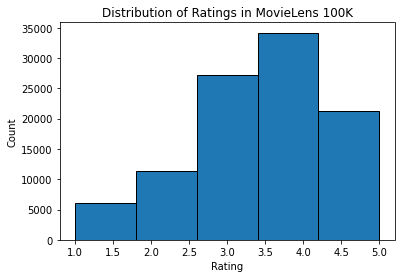

In [8]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

Splitting the dataset

Sequence-aware: use old ratings to predict future recommendations

In [9]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

Loading the data

In [10]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [14]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

# Matrix Factorization

The model factorizes the user-item interaction matrix (rating matrix) into the product of two lower-rank matrices, capturing the low-rank structure of the user-item interactions.

User latent matrix P x item latent matrix Q

User specific and item specific bias terms

In [16]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

Model implementation

In [17]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

evaluation metric: root mean square error

In [19]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

Training and evaluation the model

L2 loss with weight decay

In [20]:
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 0.064, test RMSE 1.057
130493.0 examples/sec on [cpu(0)]


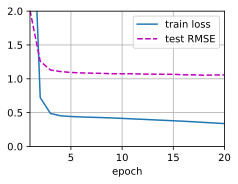

In [21]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

In [22]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

array([3.141237])

# AutoRec: Rating prediction with autoencoders

Matrix factorization model is linear, thus, such models are unable to capture complex nonlinear and intricate relationships that may be predictive of users' preferences.

AutoRec is a nonlinear neural network collaborativee filtering model. It identifies collaborative filtering (CF) with an autoencoder architecture and aims to integrate nonlinear transformation into CF on the basis of explicit feedback.

An **autoencoder** is a neural network that learns to copy its input to its output in order to code the inputs into the hidden (usually low-dimensional) representations. In AutoRec, instead of explicitly embedding users/items into low-dimensional space, it uses the column/row of the interaction matrix as the input, then reconstructs the interaction matrix in the output layer.

AutoRec has the same structure as an autoencoder which consists of an input layer, a hidden layer, and a reconstruction layer. However, rather than learning the hidden representations, AutoRec focuses on learning/reconstructing the output layer. It uses a partially observed interaction matrix as the input, aiming to reconstruct a completed rating matrix. In the mean time, the missing entries of the input are filled in the output layer via reconstruction for the purpose of recommendation.

Two variants of AutoRec: user-based and item-based.

In [23]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

Implementation

A typical autoencoder consists of an encoder and a decoder. The encoder projects the input to hidden representations and the decoder maps the hidden layer to the reconstruction layer. The gradients of unobserved inputs are masked out to ensure that only observed ratings contribute to the learning process.

In [25]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred

In [26]:
def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

Training and evaluating

train loss 0.000, test RMSE 0.916
6322415.1 examples/sec on [cpu(0)]


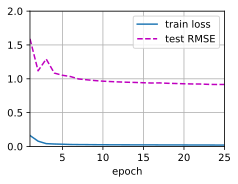

In [27]:
devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)

# Personalized ranking for recommender systems

Previous models are trained and tested on observed ratings. 

Targeting at generating ranked recommendation lists from implicit feadback have gained popularity.

**Bayesian personalized ranking (BPR) loss and its implemention**

A pairwise personalized ranking loss that is derived from the maximum posterior estimator.

In [28]:
from mxnet import gluon, np, npx

npx.set_np()

In [29]:
class BPRLoss(gluon.loss.Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(BPRLoss, self).__init__(weight=None, batch_axis=0, **kwargs)

    def forward(self, positive, negative):
        distances = positive - negative
        loss = - np.sum(np.log(npx.sigmoid(distances)), 0, keepdims=True)
        return loss

**Hinge loss and its implementation**

Similar to BPR, it aims to optimize for relevant distance between positive and negative samples instead of absolute outputs, making it well suited to recommender systems.

In [30]:
class HingeLossbRec(gluon.loss.Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(HingeLossbRec, self).__init__(weight=None, batch_axis=0,
                                            **kwargs)

    def forward(self, positive, negative, margin=1):
        distances = positive - negative
        loss = np.sum(np.maximum(- distances + margin, 0))
        return loss

# Neural collaborative filtering for personalized ranking

Moving beyond explicit feedback, introducing the neural collaborative filtering (NCF) framework for recommendation with implicit feedback. 

NeuMF (Neural Matrix Factorization), aims at enhancing model expressiveness. The model is structured with two subnetworks including generalized matrix factorization (GMF) and MLP, modeling the interactions from two pathways instead of simple dot products. The outputs of these two networks are concatenated for the final prediction scores calculation. Unlike the rating prediction task in AutoRec, this model generates a ranked recommendation list to each user based on the implicit feedback. 

**NeuMF Model**

GMF is a generic neural network version of matrix factorization. 

In [6]:
import random
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

Model implementation

In [7]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(nn.Dense(num_hiddens, activation='relu',
                                  use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid', use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

Customized dataset with negative sampling

The model ensures that the items that a user likes to be ranked higher than items he dislikes or has not interacted with

In [8]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

Evaluator

In [9]:
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

In [10]:
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(
            gluon.data.ArrayDataset(*x), shuffle=False, last_batch="keep",
            batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [gluon.utils.split_and_load(v, devices, even_split=False)
                 for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

Training and evaluation

In [11]:
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [net(*t) for t in zip(*input_data[0:-2],
                                              input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean()/len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [12]:
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items ), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

In [13]:
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

train loss 33.964, test hit rate 0.075, test AUC 0.531
2.7 examples/sec on [cpu(0)]


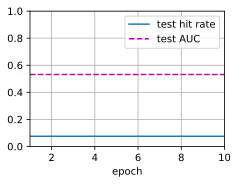

In [14]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)

**Summary:**
- Adding nonlinearity to matrix factorization model is beneficial for improving the model capability and effectiveness
- NeuMF is a combination of matrix factorization and multilayer perceptron. The multilayer perceptron takes the concatenation of user and item embeddings as the input.

# Sequence-aware recommender systems

Input is an ordered and often timestamped list of past user actions.

Caser (convolutional sequence embedding recommendation model). Main component consists of a horizontal convolutional network and a vertical convolutional network, aiming to uncover the union-level and point-level sequence patterns, respectively. Point-level pattern indicates the impact of single item in the historical sequence on the target item, while union level pattern implies the influences of several previous actions on the subsequence target. 

In [15]:
import random
import mxnet as mx
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

a vertical convolutional layer, a horizontal convolutional layer, and a fully-connected layer

In [16]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully-connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

**Sequential dataset with negative sampling**

User identity, previous L interacted items as a sequence and the next item he interacts as the target.

In [17]:
class SeqDataset(gluon.data.Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, u_ids.asnumpy(), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])

Load Movielens dataset

In [18]:
TARGET_NUM, L, batch_size = 1, 5, 4096
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=d2l.get_dataloader_workers())
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

(array(0, dtype=int32),
 array([241., 170., 110., 255.,   4.]),
 array([101.]),
 1339)

Train the model

train loss 1.719, test hit rate 0.400, test AUC 0.748
8.3 examples/sec on [cpu(0)]


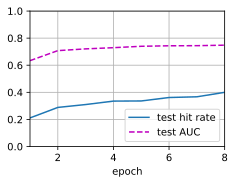

In [19]:
devices = d2l.try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.04, 8, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

d2l.train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices,
                  d2l.evaluate_ranking, candidates, eval_step=1)

Summary:
- Inferring a user's short-term and long-term interests can make prediction of the next item that he preferred more effectively
- Concolutional neural networks can be utilized to capture users' short-term interests from sequential interactions

# Feature-rich recommender systems

Interaction data is usually extremely sparse and can be noisy at times. To address this issue, we can integrate side information such as features of items, profiles of users, and even in which context that the interaction occured into the recommendation model. 

Click-through rate (CTR) for online advertisement recommendations = # clicks / # impressions x 100%

In [20]:
import os
from collections import defaultdict
from mxnet import gluon, np
from d2l import mxnet as d2l

An online advertising dataset

target + categorical variables

In [21]:
d2l.DATA_HUB['ctr'] = (d2l.DATA_URL + 'ctr.zip',
                       'e18327c48c8e8e5c23da714dd614e390d369843f')

data_dir = d2l.download_extract('ctr')

In [23]:
class CTRDataset(gluon.data.Dataset):
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int))
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance
                self.count = self.count + 1
        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                               min_threshold} for i, cnt in feat_cnts.items()}
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) + 1
        self.offsets = np.array((0, *np.cumsum(self.field_dims).asnumpy()
                                 [:-1]))

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1])
                         for i, v in enumerate(self.data[idx]['x'])])
        return feat + self.offsets, self.data[idx]['y']

Each value represents the one-hot index of the corresponding entry

In [24]:
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'))
train_data[0]

(array([ 143.,  144.,  227.,  259.,  957., 1250., 1471., 1566., 1624.,
        1690., 2008., 2061., 2143., 2304., 2305., 2360., 2745., 2746.,
        2747., 2748., 2892., 2988., 3165., 3181., 3194., 3195., 3638.,
        3662., 3687., 3701., 3729., 3748., 3767., 3794.]), [1.0])

**Summary:**
- Click-through rate is an important metric that is used to measure the effectiveness of advertising systems and recommender systems
- Click-through rate prediction is usually converted to a binary classification problem. The target is to predict whether an ad/item will be clicked or not based on given features.

# Factorization Machines

FM is a supervised algorthm that can be used for classification, regression, and ranking tasks. It is a generalization of the linear regression model and the matrix factorization model. Also a reminiscent of SVM with a polynomial kernel. 

To learn the FM model, we can use the MSE loss for regression task, the cross-entropy loss for classification tasks, and the BPR loss for ranking task. 

In [22]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [25]:
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return x

In [26]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

loss 0.505, train acc 0.271, test acc 0.272
7143.8 examples/sec on [cpu(0)]


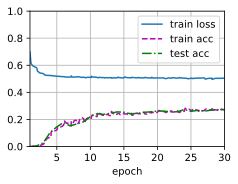

In [27]:
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

**Summary:**
- FM is a general framework that can be applied on a variety of tasks such as regression, classification, and ranking
- Feature interaction/crossing is important for prediction tasks and the 2-way interaction can be efficiently modeled with FM

# Deep Factorization Machines

Factorization machines model feature interactions in a linear paradigm (bilinear interactions). One efficient solution is using deep neural networks. 

DeepFM combines FM and deep neural networks. The two components are integrated in a parallel structure. The two components share the same inputs/embeddings and their outputs are summed up as the final prediction. 



In [28]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [29]:
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

loss 0.511, train acc 0.492, test acc 0.493
10409.9 examples/sec on [cpu(0)]


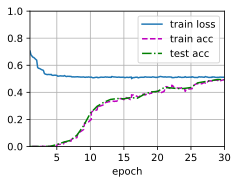

In [30]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Summary:
- Integrating neural networks to FM enables it to model complex and high-order interactions
- DeepFM outperforms the original FM on the advertising datset